In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

os.chdir(r"C:\Users\Aman Khatri\Desktop\Work\AAM\Predictive Maintenance")

In [2]:
### LOAD TRAIN ###
train_df = pd.read_csv(os.getcwd()+r'/Data Files/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(train_df.id.unique()))
train_df = train_df.sort_values(['id','cycle'])
print(train_df.shape)
train_df.head(3)

#id: 100
(20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442


medium working time: 206.31
max working time: 362
min working time: 128


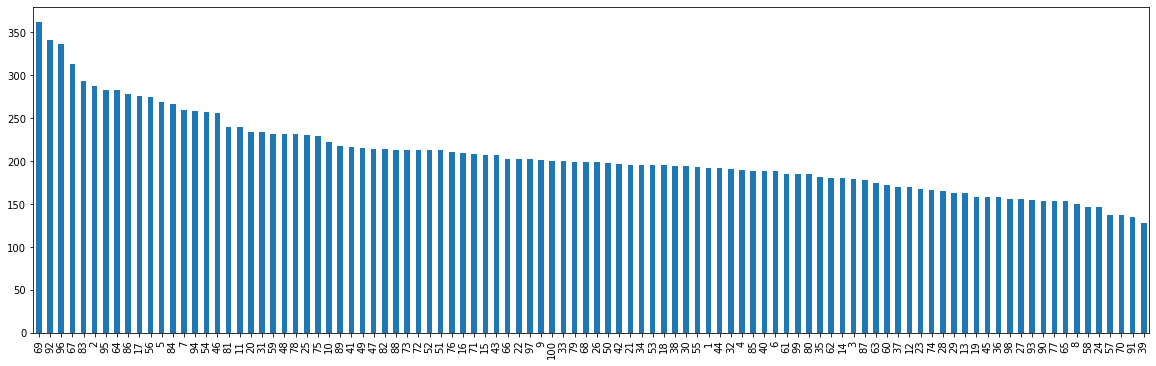

In [3]:
### PLOT TRAIN FREQ ###
plt.figure(figsize=(20,6))
train_df.id.value_counts().plot.bar()
print("medium working time:", train_df.id.value_counts().mean())
print("max working time:", train_df.id.value_counts().max())
print("min working time:", train_df.id.value_counts().min())

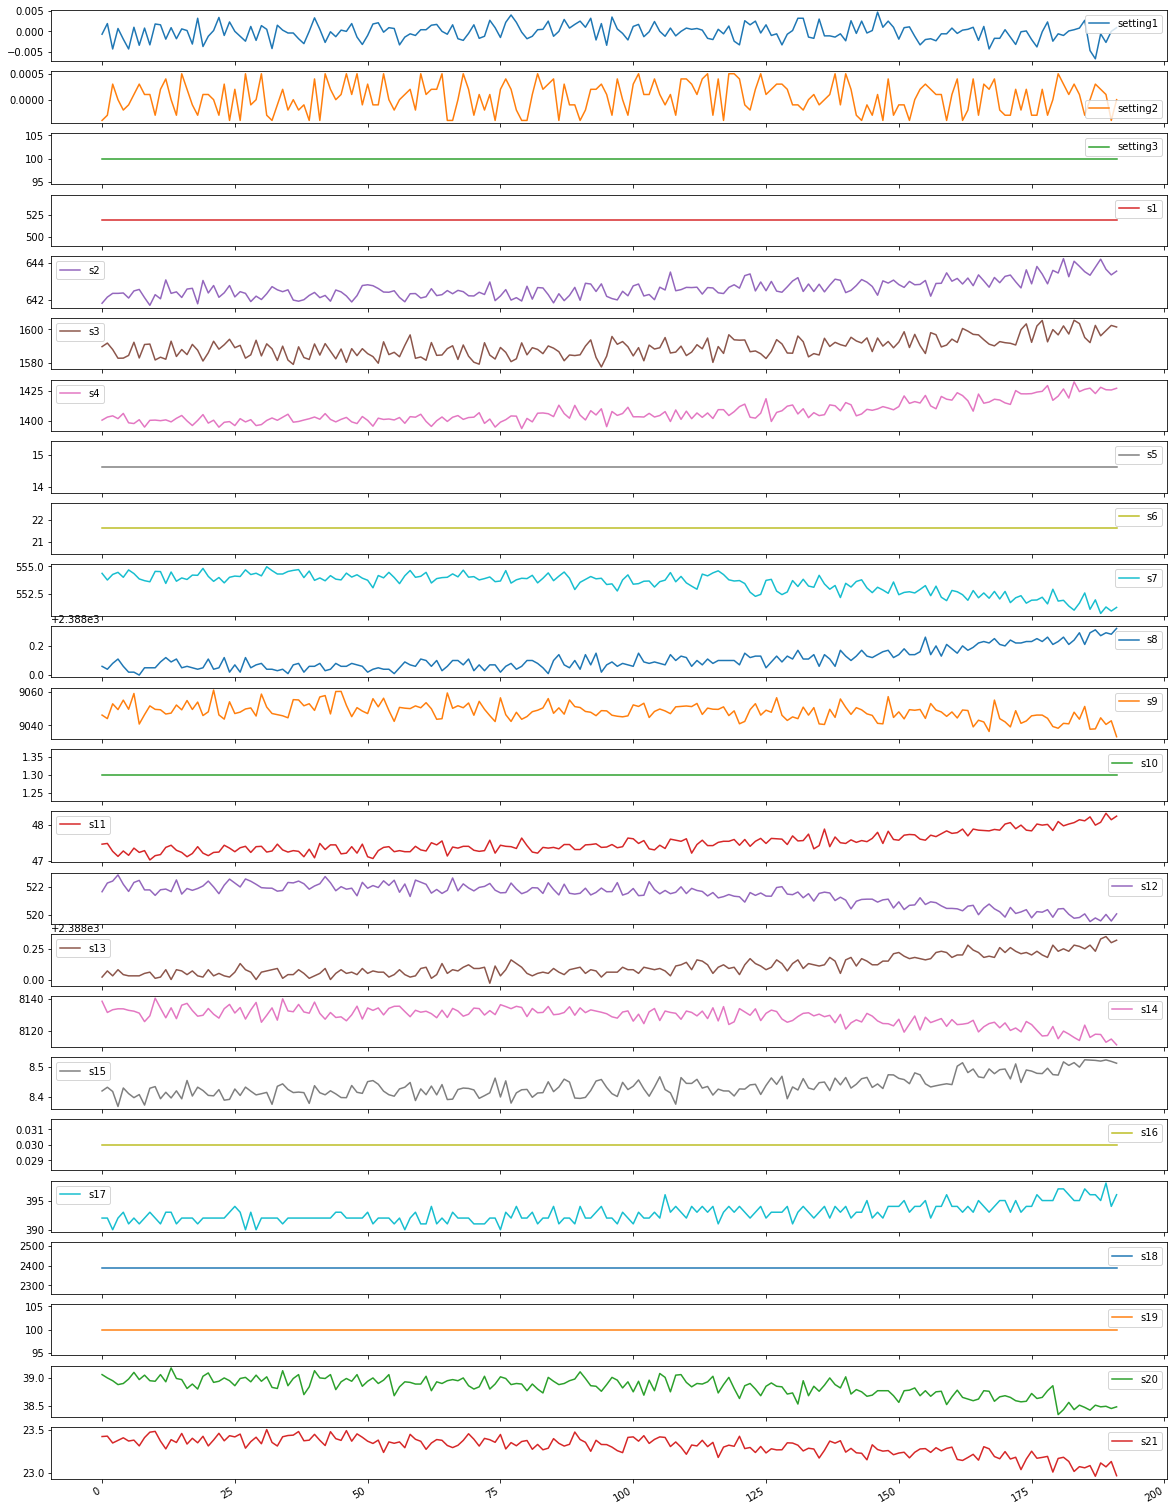

In [4]:
### plotting sensor data for engine ID ###
engine_id = train_df[train_df['id'] == 1]

ax1 = engine_id[train_df.columns[2:]].plot(subplots=True, sharex=True, figsize=(20,30))

In [5]:
### LOAD TEST ###
test_df = pd.read_csv(os.getcwd()+'/Data Files/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(test_df.id.unique()))
print(test_df.shape)
test_df.head(3)

#id: 100
(13096, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


In [6]:
### LOAD GROUND TRUTH ###
truth_df = pd.read_csv(os.getcwd()+'/Data Files/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.columns = ['more']
truth_df = truth_df.set_index(truth_df.index + 1)

print(truth_df.shape)
truth_df.head(3)

(100, 1)


,more
1,112
2,98
3,69


In [7]:
### CALCULATE RUL TRAIN ###
train_df['RUL']=train_df.groupby(['id'])['cycle'].transform(max)-train_df['cycle']
train_df.RUL[0:10]

0    191
1    190
2    189
3    188
4    187
5    186
6    185
7    184
8    183
9    182
Name: RUL, dtype: int64

In [8]:
### ADD NEW LABEL TRAIN ###
w1 = 45
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [9]:
### SCALE TRAIN DATA ###

def scale(df):
    #return (df - df.mean())/df.std()
    return (df - df.min())/(df.max()-df.min())

for col in train_df.columns:
    if col[0] == 's':
        train_df[col] = scale(train_df[col])
#     elif col == 'cycle':
#         train_df['cycle_norm'] = scale(train_df[col])
        
train_df = train_df.dropna(axis=1)
train_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,...,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,...,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,...,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,...,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,...,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0,0


In [10]:
### CALCULATE RUL TEST ###
truth_df['max'] = test_df.groupby('id')['cycle'].max() + truth_df['more']
test_df['RUL'] = [truth_df['max'][i] for i in test_df.id] - test_df['cycle']

In [11]:
### ADD NEW LABEL TEST ###
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [12]:
### SCALE TEST DATA ###

for col in test_df.columns:
    if col[0] == 's':
        test_df[col] = scale(test_df[col])
#     elif col == 'cycle':
#         test_df['cycle_norm'] = scale(test_df[col])
        
test_df = test_df.dropna(axis=1)
test_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.65625,0.692308,0.596215,0.421968,0.282214,1.0,0.608871,0.365854,...,0.534247,0.325581,0.152259,0.347076,0.375,0.500000,0.620099,142,0,0
1,1,2,0.34375,0.230769,0.182965,0.504025,0.225240,1.0,0.800403,0.292683,...,0.634703,0.395349,0.277907,0.227709,0.500,0.645455,0.645718,141,0,0
2,1,3,0.53125,0.538462,0.419558,0.464814,0.346130,1.0,0.651210,0.390244,...,0.591324,0.325581,0.192892,0.533557,0.500,0.700000,0.681104,140,0,0
3,1,4,0.77500,0.461538,0.413249,0.391587,0.449867,1.0,0.643145,0.341463,...,0.456621,0.372093,0.217896,0.282359,0.250,0.627273,0.620382,139,0,0
4,1,5,0.60000,0.461538,0.435331,0.471306,0.357974,1.0,0.661290,0.292683,...,0.632420,0.325581,0.187891,0.337009,0.125,0.618182,0.676008,138,0,0


# GEN SEQUENCE

In [13]:
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 (start stop) -> from row 0 to row 50
    # 1 51 (start stop) -> from row 1 to row 51
    # 2 52 (start stop) -> from row 2 to row 52
    # ...
    # 141 191 (start stop) -> from row 141 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [14]:
### SEQUENCE COL: COLUMNS TO CONSIDER ###
sequence_cols = []
for col in train_df.columns:
    if col[0] == 's':
        sequence_cols.append(col)
#sequence_cols.append('cycle_norm')
print(sequence_cols)

['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


# 2 Class Classification

In [35]:
### GENERATE X TRAIN TEST ###
x_train, x_test = [], []
for engine_id in train_df.id.unique():
    for sequence in gen_sequence(train_df[train_df.id==engine_id], sequence_length, sequence_cols):
        x_train.append(sequence)
    for sequence in gen_sequence(test_df[test_df.id==engine_id], sequence_length, sequence_cols):
        x_test.append(sequence)
    
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

print("X_Train shape:", x_train.shape)
print("X_Test shape:", x_test.shape)

X_Train shape: (15631, 50, 17)
X_Test shape: (8162, 50, 17)


In [36]:
### GENERATE Y TRAIN TEST ###
y_train, y_test = [], []
for engine_id in train_df.id.unique():
    for label in gen_labels(train_df[train_df.id==engine_id], sequence_length, ['label1'] ):
        y_train.append(label)
    for label in gen_labels(test_df[test_df.id==engine_id], sequence_length, ['label1']):
        y_test.append(label)
    
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)


print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (15631, 1)
y_test shape: (8162, 1)


In [37]:
### ENCODE LABEL ###
y_train = tf.keras.utils.to_categorical(y_train)
print(y_train.shape)

y_test = tf.keras.utils.to_categorical(y_test)
print(y_test.shape)

(15631, 2)
(8162, 2)


# MODEL

In [38]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [41]:
model = Sequential()
#input
model.add(LSTM(units=50, return_sequences='true', activation='tanh',
input_shape = (x_train.shape[1], x_train.shape[2])) )
model.add(Dropout(0.2))
#hidden layer 1
model.add(LSTM(units=60, return_sequences='true',activation='tanh'))
model.add(Dropout(0.2))
#hidden layer 2
model.add(LSTM(units=60, activation='tanh'))
model.add(Dropout(0.2))
#output
model.add(Dense(units=2,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 50)            13600     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 60)            26640     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 60)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [64]:
set_seed(33)

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=6)

model.fit(x_train, y_train, batch_size=512, epochs=25, callbacks=[es],
          validation_split=0.2, verbose=2)

# model.fit(x_train, y_train,batch_size=32, epochs=30)

Epoch 1/30
489/489 [==============================] - 20s 38ms/step - loss: 0.1488 - accuracy: 0.9390
Epoch 2/30
489/489 [==============================] - 20s 42ms/step - loss: 0.1173 - accuracy: 0.9527
Epoch 3/30
489/489 [==============================] - 21s 44ms/step - loss: 0.1071 - accuracy: 0.9542
Epoch 4/30
489/489 [==============================] - 21s 42ms/step - loss: 0.0990 - accuracy: 0.9568
Epoch 5/30
489/489 [==============================] - 21s 43ms/step - loss: 0.0955 - accuracy: 0.9592
Epoch 6/30
489/489 [==============================] - 20s 42ms/step - loss: 0.0863 - accuracy: 0.9632
Epoch 7/30
489/489 [==============================] - 22s 44ms/step - loss: 0.0878 - accuracy: 0.9644
Epoch 8/30
489/489 [==============================] - 22s 45ms/step - loss: 0.0865 - accuracy: 0.9617
Epoch 9/30
489/489 [==============================] - 21s 43ms/step - loss: 0.0833 - accuracy: 0.9653
Epoch 10/30
489/489 [==============================] - 21s 42ms/step - loss: 0.077

In [65]:
model.evaluate(x_test, y_test, verbose=2)

256/256 - 3s - loss: 1.6415 - accuracy: 0.7980


[1.6414923667907715, 0.7979661822319031]

In [66]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [67]:
print(classification_report(np.where(y_test != 0)[1], model.predict_classes(x_test)))

C:\Users\Aman Khatri\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       1.00      0.78      0.88      7426
           1       0.31      0.99      0.47       736

    accuracy                           0.80      8162
   macro avg       0.65      0.89      0.67      8162
weighted avg       0.94      0.80      0.84      8162



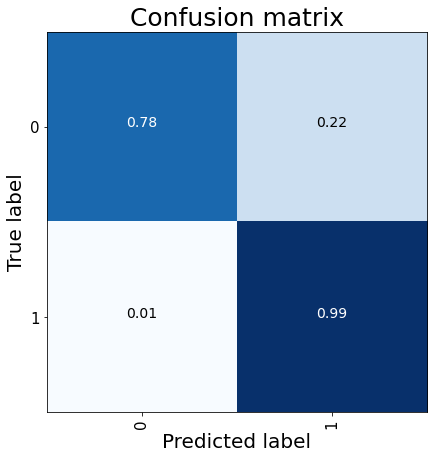

In [68]:
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model.predict_classes(x_test))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
plt.show()

In [69]:
from sklearn.metrics import roc_auc_score
2*roc_auc_score(np.where(y_test != 0)[1], model.predict_proba(x_test)[:,1])-1

C:\Users\Aman Khatri\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


0.9369966641881053

# 3- Class Classification

In [15]:
### GENERATE X TRAIN TEST ###
x_train, x_test = [], []
for engine_id in train_df.id.unique():
    for sequence in gen_sequence(train_df[train_df.id==engine_id], sequence_length, sequence_cols):
        x_train.append(sequence)
    for sequence in gen_sequence(test_df[test_df.id==engine_id], sequence_length, sequence_cols):
        x_test.append(sequence)
    
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

print("X_Train shape:", x_train.shape)
print("X_Test shape:", x_test.shape)

X_Train shape: (15631, 50, 17)
X_Test shape: (8162, 50, 17)


In [16]:
### GENERATE Y TRAIN TEST ###
y_train, y_test = [], []
for engine_id in train_df.id.unique():
    for label in gen_labels(train_df[train_df.id==engine_id], sequence_length, ['label2'] ):
        y_train.append(label)
    for label in gen_labels(test_df[test_df.id==engine_id], sequence_length, ['label2']):
        y_test.append(label)
    
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)


print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (15631, 1)
y_test shape: (8162, 1)


In [17]:
### ENCODE LABEL ###
y_train = tf.keras.utils.to_categorical(y_train)
print(y_train.shape)

y_test = tf.keras.utils.to_categorical(y_test)
print(y_test.shape)

(15631, 3)
(8162, 3)


# MODEL

In [21]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [28]:
model = Sequential()
#input
model.add(LSTM(units=50, return_sequences='true', activation='tanh',
input_shape = (x_train.shape[1], x_train.shape[2])) )
model.add(Dropout(0.2))
#hidden layer 1
model.add(LSTM(units=60, return_sequences='true',activation='tanh'))
model.add(Dropout(0.2))
#hidden layer 2
model.add(LSTM(units=60, activation='tanh'))
model.add(Dropout(0.2))
#output
model.add(Dense(units=3,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 50)            13600     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 60)            26640     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 60)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

In [29]:
set_seed(33)

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=6)

model.fit(x_train, y_train, batch_size=512, epochs=25, callbacks=[es],
          validation_split=0.2, verbose=2)

# model.fit(x_train, y_train,batch_size=32, epochs=30)

Epoch 1/25
25/25 - 16s - loss: 0.7114 - accuracy: 0.6991 - val_loss: 0.4570 - val_accuracy: 0.8020
Epoch 2/25
25/25 - 10s - loss: 0.4025 - accuracy: 0.8351 - val_loss: 0.3551 - val_accuracy: 0.8340
Epoch 3/25
25/25 - 10s - loss: 0.2661 - accuracy: 0.8909 - val_loss: 0.2084 - val_accuracy: 0.9159
Epoch 4/25
25/25 - 10s - loss: 0.2019 - accuracy: 0.9172 - val_loss: 0.1671 - val_accuracy: 0.9370
Epoch 5/25
25/25 - 10s - loss: 0.1938 - accuracy: 0.9202 - val_loss: 0.1764 - val_accuracy: 0.9293
Epoch 6/25
25/25 - 10s - loss: 0.1745 - accuracy: 0.9290 - val_loss: 0.1716 - val_accuracy: 0.9255
Epoch 7/25
25/25 - 10s - loss: 0.1619 - accuracy: 0.9336 - val_loss: 0.1481 - val_accuracy: 0.9408
Epoch 8/25
25/25 - 10s - loss: 0.1522 - accuracy: 0.9371 - val_loss: 0.1582 - val_accuracy: 0.9332
Epoch 9/25
25/25 - 10s - loss: 0.1630 - accuracy: 0.9325 - val_loss: 0.1694 - val_accuracy: 0.9245
Epoch 10/25
25/25 - 10s - loss: 0.1530 - accuracy: 0.9360 - val_loss: 0.1838 - val_accuracy: 0.9229
Epoch 11/

In [30]:
model.evaluate(x_test, y_test, verbose=2)

256/256 - 2s - loss: 0.8146 - accuracy: 0.7915


[0.814642608165741, 0.7914726734161377]

In [31]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [33]:
print(classification_report(np.where(y_test != 0)[1], model.predict_classes(x_test)))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      7426
           1       0.19      0.43      0.27       676
           2       0.11      1.00      0.20        60

    accuracy                           0.79      8162
   macro avg       0.43      0.75      0.46      8162
weighted avg       0.93      0.79      0.84      8162



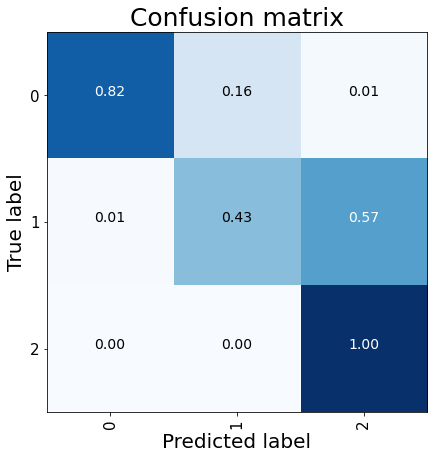

In [34]:
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model.predict_classes(x_test))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
plt.show()